CUDA is available
Federated Learning Round 1


C:\Users\54052\AppData\Local\Temp\ipykernel_19376\445801894.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  client_weights[-1].append(torch.tensor(param.data))


Loss on the test set: 0.0369, Accuracy on the test set: 10.98%
Federated Learning Round 2
Loss on the test set: 0.0366, Accuracy on the test set: 13.07%
Federated Learning Round 3
Loss on the test set: 0.0362, Accuracy on the test set: 15.85%
Federated Learning Round 4
Loss on the test set: 0.0360, Accuracy on the test set: 16.88%
Federated Learning Round 5
Loss on the test set: 0.0360, Accuracy on the test set: 16.67%
Federated Learning Round 6
Loss on the test set: 0.0361, Accuracy on the test set: 16.40%
Federated Learning Round 7
Loss on the test set: 0.0361, Accuracy on the test set: 16.42%
Federated Learning Round 8
Loss on the test set: 0.0361, Accuracy on the test set: 16.35%
Federated Learning Round 9
Loss on the test set: 0.0361, Accuracy on the test set: 16.21%
Federated Learning Round 10
Loss on the test set: 0.0360, Accuracy on the test set: 17.03%


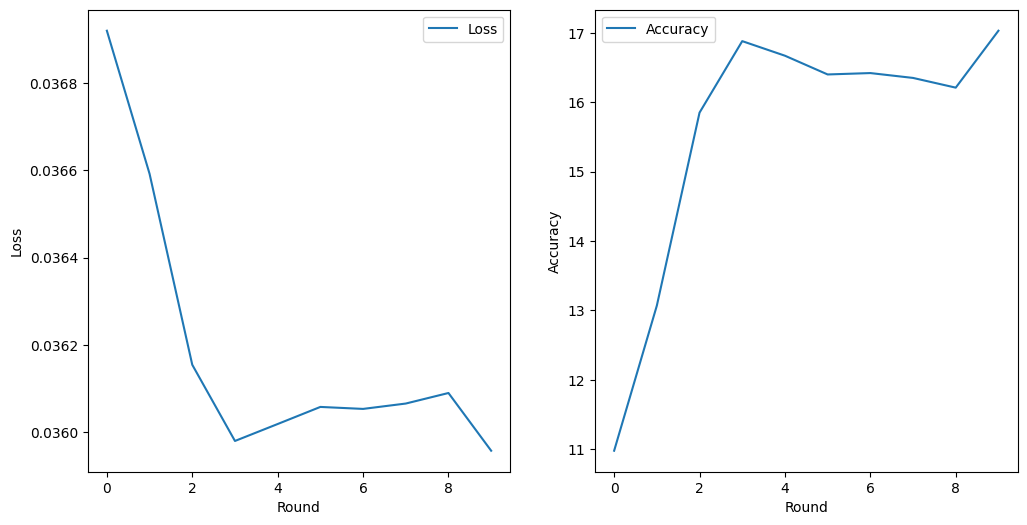

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Create a transform to convert the images to tensors and normalize them
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Create a training dataset using the MNIST dataset, with the transform applied
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a testing dataset using the MNIST dataset, with the transform applied
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

class LoRAModule(nn.Module):
    def __init__(self, original_module, r=4):
        super(LoRAModule, self).__init__()
        self.original_module = original_module
        self.r = r
        
        # 定义低秩矩阵
        # 获取原始模块的输入特征数和输出特征数
        in_features = original_module.in_features
        out_features = original_module.out_features
        # 定义A参数，形状为输入特征数和r
        self.A = nn.Parameter(torch.randn(in_features, r))
        # 定义B参数，形状为r和输出特征数
        self.B = nn.Parameter(torch.randn(r, out_features))

    def forward(self, x):
        # 计算低秩适应
        # 获取原始模块的输出
        original_output = self.original_module(x)
        # 获取低秩输出的结果
        low_rank_output = x @ self.A @ self.B
        # 返回原始输出和低秩输出的和
        return original_output + low_rank_output

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = LoRAModule(nn.Linear(28 * 28, 200), r=4)
        self.relu = nn.ReLU()
        self.fc2 = LoRAModule(nn.Linear(200, 10), r=4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Split dataset according to labels
label_dict = {}
for idx, (data, target) in enumerate(train_data):
    if target not in label_dict:
        label_dict[target] = []
    label_dict[target].append((data, target))

# Create client datasets
num_clients = 10
client_datasets = []
for i in range(num_clients):
    client_data = label_dict[i]  # Extract data for the i-th label
    client_datasets.append(client_data)

# Create data loaders for each client
clients = []
for client_data in client_datasets:
    data = []
    targets = []
    for sample in client_data:
        data.append(sample[0])
        targets.append(sample[1])
    data = torch.stack(data)
    targets = torch.tensor(targets)
    client_dataset = TensorDataset(data, targets)
    client_loader = DataLoader(client_dataset, batch_size=64, shuffle=True)
    clients.append(client_loader)

# Define a global model
global_model = SimpleNN()

# Move the model to GPU
if torch.cuda.is_available():
    print("CUDA is available")
else:
    print("CUDA is not available")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_model.to(device)

# Define a function to average the weights of the clients
def federated_avg(weights):
    # Calculate the average of the weights for each layer
    avg_weights = []
    for layer in range(len(weights[0])):
        layer_weights = []
        for client_weights in weights:
            layer_weights.append(client_weights[layer])
        avg_weights.append(torch.mean(torch.stack(layer_weights), dim=0))
    return avg_weights


# Define the number of rounds for federated learning
num_rounds = 10
num_epochs = 5
criterion = nn.CrossEntropyLoss()

# Start federated learning
losses = []
accuracies = []
for round_num in range(num_rounds):
    # Start federated learning round number round_num
    print(f'Federated Learning Round {round_num + 1}')
    client_weights = []
    
    # Loop through the clients
    for client_data in clients:
        model = SimpleNN()
        # Move the model to GPU
        model.to(device)
        # Load the global model parameters
        model.load_state_dict(global_model.state_dict())
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        
        model.train()
        # Train the model with the client data
        for epoch in range(num_epochs):  # Number of training rounds for each client
            for x_client, y_client in client_data:
                # Move the data to GPU
                x_client, y_client = x_client.to(device), y_client.to(device)
                optimizer.zero_grad()
                outputs = model(x_client)
                loss = criterion(outputs, y_client)
                loss.backward()
                optimizer.step()
        
        # Add the client model parameters to the client_weights list
        client_weights.append([])
        for param in model.parameters():
            client_weights[-1].append(torch.tensor(param.data))

    
    # Aggregate weight
    new_weights = federated_avg(client_weights)
    # Update the global model weights
    for i, param in enumerate(global_model.parameters()):
        param.data = new_weights[i]

    # Evaluate the global model on the test set
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
    global_model.eval() 
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            # Move the data to GPU
            x_test, y_test = x_test.to(device), y_test.to(device)
            outputs = global_model(x_test)
            loss = criterion(outputs, y_test)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / total
    losses.append(test_loss)
    accuracies.append(accuracy)
    print(f'Loss on the test set: {test_loss:.4f}, Accuracy on the test set: {accuracy:.2f}%')

# Plot the losses and accuracies
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
